In [6]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

# GradCAM (from scratch)

ref: https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

dataset is structured as needed by ImageNet, we use vgg16 instead

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 9.3 MB/s eta 0:00:00


In [3]:
import shap
import torch
from torchvision import transforms

X, y = shap.datasets.imagenet50()

In [13]:
# def get_inv_transform(img):
#   img = torch.Tensor(img)
inverse_transformation = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                      std = [ 1., 1., 1. ]),
                                ])
# unnormalized_img = inverse_transformation(img)
#   return unnormalized_img

Ground truth values: picket fence, american egret, speedboat, puck, komodo_dragon

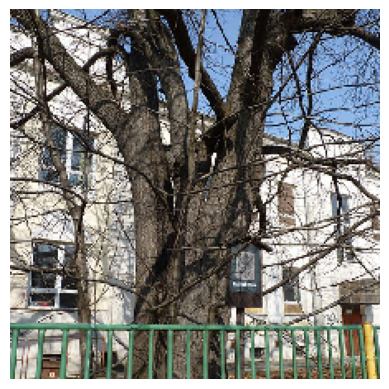

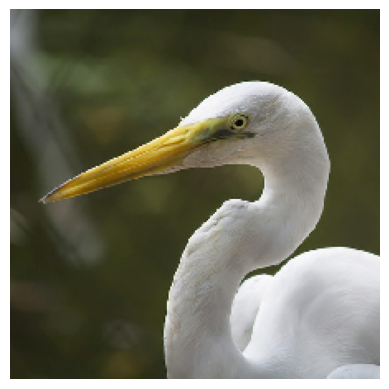

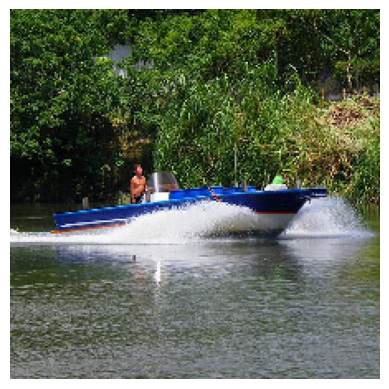

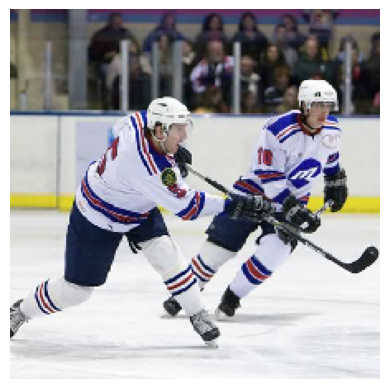

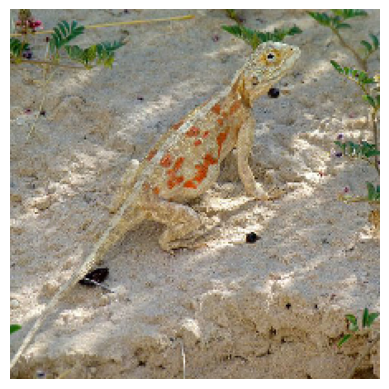

In [32]:
gt = ['picket fence', 'american egret', 'speedboat', 'puck', 'komodo_dragon']

for i in range(5):
  # im = torch.tensor(X[i]).permute(2, 1, 0)
  # im = inverse_transformation(im)
  plt.imshow(X[i].astype(int))
  plt.axis("off")
  # plt.title(gt[i])
  plt.margins(x=0)
  plt.savefig(f"im_{i}.png",bbox_inches='tight')
  plt.show()

In [65]:
# !unzip ImageNet50.zip

In [81]:
import os
dirs = os.listdir("/content/ImageNet50")

In [82]:
dirs

['puck', 'komodo_dragon', 'speedboat', 'picket_fence', 'american_egret']

In [86]:
class_nums = [746, 48, 814, 716, 132] # imagenet classes

ref: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [87]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [88]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19 # USE VGG16
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2

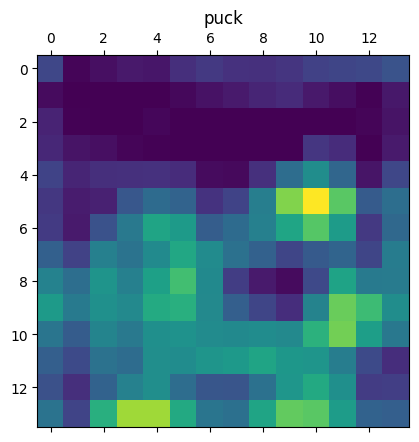

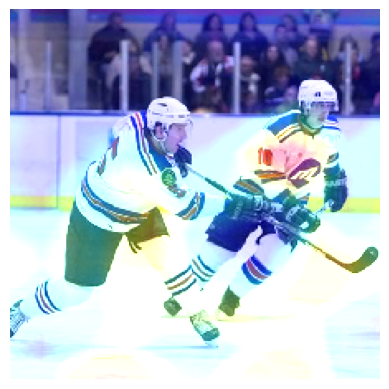

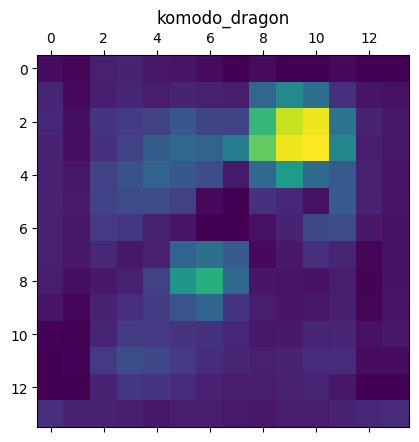

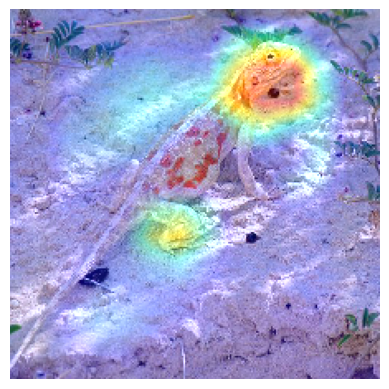

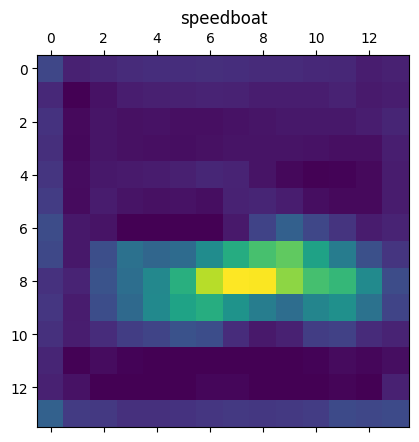

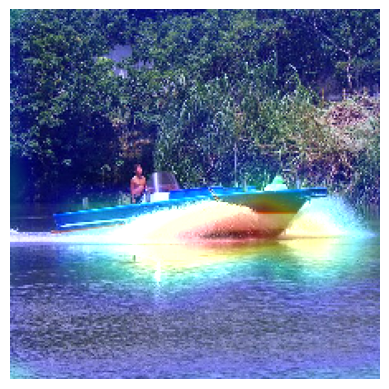

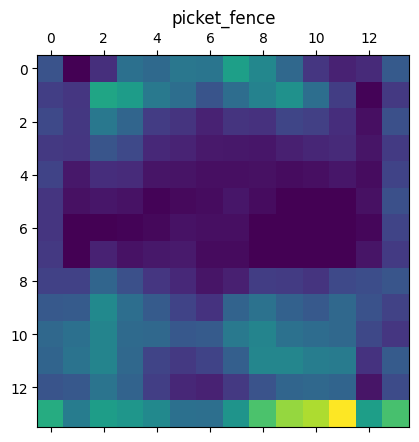

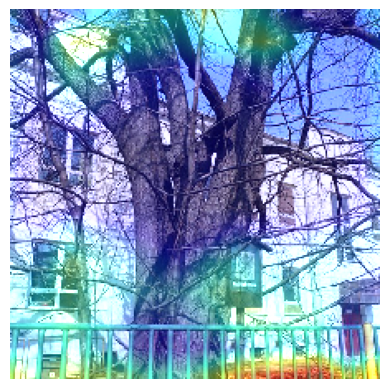

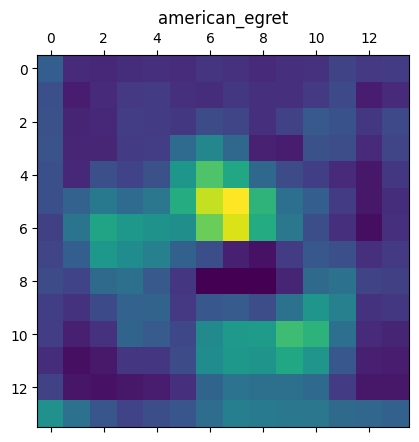

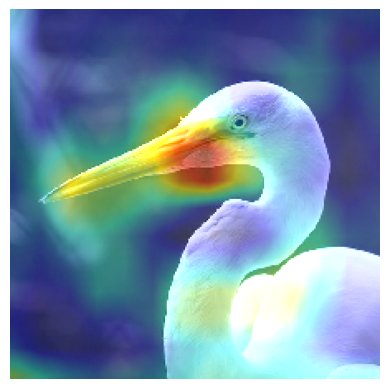

In [93]:

# refer to pytorch documentation, easier method exists
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

for i, d in enumerate(dirs): 
  path = 'ImageNet50/' + d + "/"
  # define a 1 image dataset
  dataset = datasets.ImageFolder(root=path, transform=transform)

  # define the dataloader to load that single image
  dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

  # initialize the VGG model
  vgg = VGG()

  # set the evaluation mode
  vgg.eval()

  # get the image from the dataloader
  img, _ = next(iter(dataloader))

  # get the most likely prediction of the model
  pred = vgg(img)

  c_no = class_nums[i]
  pred[:, c_no].backward() # computing wrt class numebr

  # pull the gradients out of the model
  gradients = vgg.get_activations_gradient()

  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # get the activations of the last convolutional layer
  activations = vgg.get_activations(img).detach()

  # weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]
      
  # average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  plt.matshow(heatmap.squeeze())
  plt.title(d)
  plt.show()


  heatmap = heatmap.detach().numpy()
  # print(d)
  img = cv2.imread(f'/content/ImageNet50/{d}/data/{d}.png')
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # resizing is messing things up?

  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2.imwrite(f'./map{i}.jpg', superimposed_img) # jpg compression makes it smoother
  cv2_imshow(superimposed_img)
